# Part 1: EDA and Data Preperation 

The Data used in this notebook can be found on the Kaggle competition page. Here is the description of the challenge (from Kaggle): 

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

(https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import numpy as np

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_colwidth', -1)

In this notebook we preform basic data cleaning (filling in null values), as well as basic data transformation (one-hot encoding, ordinal encoding, and Feature creation).

## Step 1: Import Training Dataset and Basic Data Exploration

The first thing we have to do after importing our packages is to upload the Dataset from the Kaggle competition page. We should also check the shape of the Dataset and the Feature Names to have a better understanding of the composition of our Dataset.

In [25]:
#uplaod traning data from s3 bucket

data_location= 'raw_housing_data.csv'
df = pd.read_csv(data_location, low_memory=False)
df=df.set_index('Id')

In [26]:
#take a look at the size of our data and our column names 
print(df.shape)
df.columns

(1460, 80)


Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

We should also take a look to see how many null values we have in our quantative variables. We will replace these null values with the median. 

In [30]:
#check to see null values in our quantative variables

(df.describe().loc['count']/df.shape[0])

MSSubClass       1.0
LotFrontage      1.0
LotArea          1.0
OverallQual      1.0
OverallCond      1.0
YearBuilt        1.0
YearRemodAdd     1.0
MasVnrArea       1.0
BsmtFinSF1       1.0
BsmtFinSF2       1.0
BsmtUnfSF        1.0
TotalBsmtSF      1.0
1stFlrSF         1.0
2ndFlrSF         1.0
LowQualFinSF     1.0
GrLivArea        1.0
BsmtFullBath     1.0
BsmtHalfBath     1.0
FullBath         1.0
HalfBath         1.0
BedroomAbvGr     1.0
KitchenAbvGr     1.0
TotRmsAbvGrd     1.0
Fireplaces       1.0
GarageYrBlt      1.0
GarageCars       1.0
GarageArea       1.0
WoodDeckSF       1.0
OpenPorchSF      1.0
EnclosedPorch    1.0
3SsnPorch        1.0
ScreenPorch      1.0
PoolArea         1.0
MiscVal          1.0
MoSold           1.0
YrSold           1.0
SalePrice        1.0
Name: count, dtype: float64

In [31]:
df=df.fillna(dict(zip(df.describe().columns, df.describe().loc['50%'])))

Lets take a more detailed look into our Target Variable. We can clearly that it is skewed to the right.   

In [33]:
#descriptive stats for SalePrice

df_Price= df['SalePrice']
df_Price.describe()

count    1460.000000  
mean     180921.195890
std      79442.502883 
min      34900.000000 
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

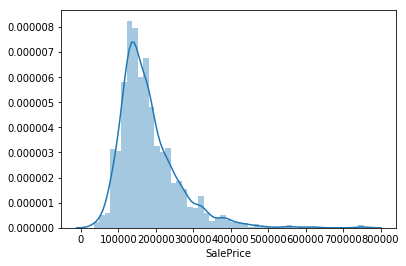

In [34]:
#look at distribution for the SalesPrice

import seaborn as sns

sns.distplot(df_Price)

## Step 2: Data Transformation and Feature Exploration

Since are data is skewed to the right, we will apply a log(1+x) transformation, but for now we will just use our original price. We will also create two new features; TotalSF which will combine the three Square Feet features into one, and TotalBath which will combine all the Bathroom features. 

In [35]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'] 

df['TotalBath'] = .5 *(df['HalfBath'] + df['BsmtHalfBath']) + df['FullBath'] + df['BsmtFullBath']

df = df[ [ col for col in df.columns if col != 'SalePrice' ] + ['SalePrice'] ]

We will begin our Feature Engineering by checking the coorelation between our Features. This can help spot co-linearity and identify the Features we need to use as part of our Model. 

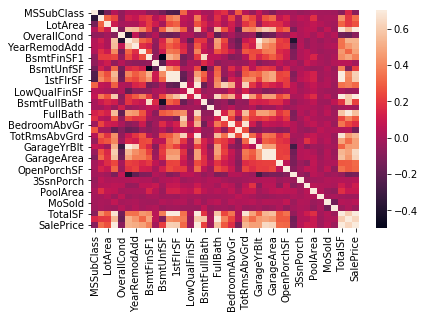

In [8]:
#correlation matrix to look at catagories with strong coorelations with SalePrice

corr_mat= df.corr()
f, ax= plt.subplots()
sns.heatmap(corr_mat,vmax=.7)

Lets take a deeper look at just the Features that have a coorelation with SalesPrice of over .35. This is also a good chance to unselect the Features with a high amount of CoLinearity 

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'TotalSF',
       'TotalBath', 'SalePrice'],
      dtype='object')


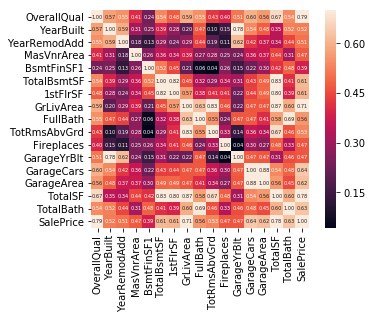

In [36]:
#selecting numerical features to be included in the model 

cols_num_all=corr_mat.loc[corr_mat['SalePrice']>.35].index #numberical features we will include
print(cols_num_all)
df_num= df[cols_num_all]
corr_mat_num=df_num.corr()
sns.heatmap(corr_mat_num, vmax=.7, cbar=True, annot=True, square=True, fmt='.2f',annot_kws={'size': 5})

In [10]:
#remove features with colinearity

cols_num=[]
for i in cols_num_all: 
    if i not in ['GarageYrBlt','GarageCars', 'BsmtFinSF1','FullBath','1stFlrSF','TotalBsmtSF','YearRemodAdd']:
        cols_num.append(i)

We can now start looking at our Categorical values, lets start by filling in the null values.

In [37]:
desc_obj=df.describe(include='object')
repl_val={'MasVnrType':'None','BsmtFinType1':'NoBas','BsmtFinType2':'NoBas','BsmtCond':'NoBas', 'BsmtExposure': 'NoBas',
         'Electrical':'Sbrkr','FireplaceQu':'NoFp','GarageType':'NoGar','GarageFinish':'NoGar','GarageQual':'NoGar','GarageCond':'NoGar',
         'PoolQC':'NoP','Fence':'NoF','BsmtQual':'NoBas'}

df= df.fillna(repl_val)
desc_obj

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


Since we can't just run a correlation matrix, one thing we can do is look at the box plots of the Feature values. After taht we should One-Hot Encode the features an check the coorelation with SalesPrice (using Linear Regerssion). This will give a general idea of which features to include. 

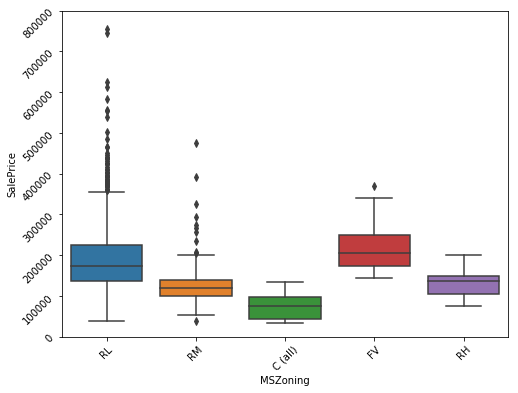

In [40]:
#go through the categorical variables to check coorelations

var = 'MSZoning'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
ax.tick_params(labelrotation=45)
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);


In [41]:
from sklearn.linear_model import LinearRegression

print(df[var].value_counts())

#used this cell for feature selection
df_dummy=pd.get_dummies(df[var])
model= LinearRegression(fit_intercept=False)
model.fit(df_dummy, df_Price)

print(df_dummy.columns)
print(model.coef_*2)

score= model.score(df_dummy,df_Price)
print(score)
col_obj=['Neighborhood','HouseStyle','ExterQual','Foundation', 'BsmtQual','BsmtExposure','KitchenQual'
         ,'GarageType','GarageFinish','RoofStyle'] #catogorical features selected 


RL         1151
RM         218 
FV         65  
RH         16  
C (all)    10  
Name: MSZoning, dtype: int64
Index(['C (all)', 'FV', 'RH', 'RL', 'RM'], dtype='object')
[149056.         428028.12307692 263116.75       382009.98957428
 252633.66055046]
0.10755968344624967


Some of our Features are Ordinal, meaning we should assign numerical values to order them. 

In [43]:
#cell used to assign oridinal features their values 

cols_ord=['ExterQual','BsmtQual','BsmtExposure','KitchenQual','GarageFinish']  #oridinal Values
cols_ohe= ['Neighborhood', 'HouseStyle', 'Foundation','GarageType'] #the values we will have to one hot encode later


var='GarageFinish' #one of the col_ord values 
df_ordinal= np.array(df[var].replace({'RFn':4,'Unf':3,'Fin':5,'NoGar':2})).reshape(-1,1)
model=LinearRegression(fit_intercept=True)
model.fit(df_ordinal,df_Price)
print(model.coef_)
print(model.intercept_)
model.score(df_ordinal,df_Price)

[48870.99420801]
-671.3682044244779


0.3016719993425554

In [44]:
#replacement of string catogrical features with ordinal value

replace= {'ExterQual':{'Ex':7,'Fa':2,'Gd':5,'TA':3,'Po':1},'BsmtQual':{'Ex':6,'Fa':2,'Gd':4,'TA':3,'Po':1,'NoBas':2},
          'BsmtExposure':{'No':3,'Gd':5,'Mn':4,'Av':4,'NoBas':2},'KitchenQual':{'TA':3,'Gd':4,'Ex':6,'Fa':2,'Po':1},
           'FireplaceQu':{'TA':2,'Gd':2.2,'Ex':3.3,'Fa':1.6,'Po':1.2,'NoFp':1.4},'GarageFinish': {'RFn':4,'Unf':3,'Fin':5,'NoGar':2}}

## Step 3: Upload Cleaned Datasets 

Finally all that is left to do is upload our dataset, we will refer these to the next Part. We will also preform our log(1+p) transformation on SalesPrice. 

In [48]:
#save a simplified csv files with all the original attributes left alone(for graphing later)

cols= cols_ord + cols_ohe + cols_num 
df_original = df[cols]
df_original.to_csv('housing_data_original.csv',index=False)

In [49]:
#creation of our 'final' cleaned dataframe

cols= cols_ord+list(cols_num)
df_cleaned=df[cols].replace(replace)
df_cleaned_dummy= pd.get_dummies(df[cols_ohe])

df_cleaned =pd.concat([df_cleaned,df_cleaned_dummy],axis=1)
df_cleaned['YearBuilt']=2020-df_cleaned['YearBuilt']

df_cleaned['SalePrice'] = np.log1p(df_Price)

In [50]:
#uplaod the data into s3 

df_cleaned.to_csv('housing_data.csv',index=False)

print(cols)

['ExterQual', 'BsmtQual', 'BsmtExposure', 'KitchenQual', 'GarageFinish', 'OverallQual', 'YearBuilt', 'MasVnrArea', 'GrLivArea', 'TotRmsAbvGrd', 'Fireplaces', 'GarageArea', 'TotalSF', 'TotalBath', 'SalePrice']


Fin